# Intro to the API and Plotting

In this tutorial you will learn how to plot data from the ONC database. To do this, we will:

- Define parameters.

- Request data from the database.

- Load the data into a DataFrame. You can think of a DataFrame as a highly organized and feature-rich table where each column represents a specific parameter, and each row represents an observation.

- Plot data from the DataFrame.

There is some basic terminology used throughout this and other notebooks. For information on the locations, devices, and properties you will need to interact with this tutorial, please see the notebook Glossary - Definitions etc.

Key words: inputs/parameters, function, library, API, DataFrame, 

### Text and code blocks

Throughout this notebook you will see text blocks (like this one) and code blocks (like the one right below). Code blocks contain python commands that you can run by clicking the little blue play button at the top of each code block (appears when you hover your cursor over the block). You will also see some green text following the character "#". These lines of green text are comments about the code (to help you understand it), and are ignored by Python.

In [1]:
print ("Hello world!") #this is a simple Python command to print the words "Hello world!"

Hello world!


### Set up programming environment

The code below installs the ONC, pandas, and matplotlib packages. When we install a package, the module is placed on to your system where it can be found and used by Python.

In [2]:
# !pip install --upgrade pip
# !pip install onc
# !pip install pandas
# !pip install matplotlib

Throughout this notebook, you’ll see several lines that look like: "import ______ from ______".

This code import libraries- external tools or packages that add extra features to Python - from our installed packages above. When you import a library, it loads the installed code into your program so you can use its functions.

For example, some libraries help us connect to online data sources (like ONC's client library), while others help with data analysis (like Pandas) or with making plots (like Matplotlib).

### 1. Define parameters

Now that our basic environment is set up, we must define what it is we want to plot. That means choosing a locationCode, propertyCode, etc, just like we did with the OpenAPI.

These selections are called parameters, and they will form the overall query that we ask the API. Recall that an API is like a server in a restaurant- you tell them what you want, they tell the kitchen, and then they deliver your food from the kitchen to you when it's ready. 

Thus, we define our parameters according to what we are interested in. 

> Define your parameters in the following block of code.

Initially, we will look at CTD data from the Folger Deep (FGPD) platform for 11 months in 2025. Later, you will replace these parameters to access and plot different data.

In [3]:
# INTERACTIVE: Modify the values to the right of ':'. Use quotes. Reference the comments (in green) for default values.
params = {
    "locationCode": "FGPD.O2",               # "FGPD" is the location code name for ONC's Folger Deep platform
    "deviceCategoryCode": "OXYSENSOR",       # "CTD" is the device category code for a Conductivity-Temperature-Depth instrument
    "dateFrom": "2025-01-01T00:00:00.000Z",  # "2025-01-01T00:00:00.000Z" is the starting date for the data you want to plot
    "dateTo": "2025-11-01T20:00:00.000Z"     # "2025-11-01T20:00:00.000Z" is the ending date for the data you want to plot
}

Note this is UTC time NOT Pacific Standard Time.

Next, the program checks if your requested time range is over 24 hours. Since the API limits responses to 100,000 lines (about 1.5 days at 1 observation per second), this code uses subsampling for longer requests by setting the resample period parameter based on the duration.

In [4]:
from datetime import datetime # Import library that recognizes your defined times as real dates in time

# Convert string inputs defined in the params above to datetime objects
start_time = datetime.fromisoformat(params['dateFrom'].replace("Z", "+00:00"))
end_time = datetime.fromisoformat(params['dateTo'].replace("Z", "+00:00"))

# Calculate the duration in hours (there are 3600 seconds in an hour)
duration_hours = (end_time - start_time).total_seconds() / 3600

# Check length of time series to request. Resample the data based on length of requested data
if duration_hours > 2190: # If greater than 3 months
    resample = 1800
elif duration_hours > 24: # If greater than 24 hours
    resample = 900
else:
    resample = None

# Set resample paramters if necessary
if resample:
    params["metadata"] = "minimum"
    params["qualityControl"] = "clean"
    params["resamplePeriod"] = resample
    params["resampleType"] = "avg"

Below are the final parameters that you will use to request data in the next step. The command print() shows all the parameters defined above as  name:value pairs—that is the name of the parameter followed by a ":" followed by the value it contains. You can see them all listed in the box below.

In [5]:
print(params) # Preview the parameters

{'locationCode': 'FGPD.O2', 'deviceCategoryCode': 'OXYSENSOR', 'dateFrom': '2025-01-01T00:00:00.000Z', 'dateTo': '2025-11-01T20:00:00.000Z', 'metadata': 'minimum', 'qualityControl': 'clean', 'resamplePeriod': 1800, 'resampleType': 'avg'}


### 2. Request data

(i) Set up API

Before you can interact with the ONC API, you need to import the onc library and connect using your token. 

The library contains special functions- small, reusable blocks of code that perform specific tasks- like getScalardata(), which we use below. 

Your token lets the API know who you are and gives you permission to access the data. You can find your token by logging into https://data.oceannetworks.ca/, viewing your profile, and clicking the Web Services API tab.

<img src="onc_token.png" width="" align="" />

> Enter your token below.

In [6]:
import onc # ONC client library
from onc import ONC 
my_onc = ONC(token="d008594a-922f-441d-87e4-be3e06faaf15") # INTERACTIVE: Enter your token here (in quotes).

(ii) Make request

Next, we request data via the API by using your parameters with the getScalarData() function, which returns raw scalar data. The following block handles any errors that might arise from trying to run this function.

In [7]:
from requests.exceptions import HTTPError # Import library to handle errors

try:
    api_response = my_onc.getScalardata(params) # Make the getScalardata request
except HTTPError as e: # Handle any issues with request and stop program
    print(f"Read the error description(s) below and adjust your input parameters accordingly.")
    print(e)
    raise SystemExit

The API will then send back a response according to your parameters. 

Below is a preview of the main sections (called headings in this example) in the API response. The sensorData section is especially important because it contains one entry for each property, where both the data and metadata for that property are stored.

In [8]:
import json # Import the json library for formatting the json response -- makes it easier to read by humans
headings = {key: str(type(value)) for key, value in api_response.items()} # Isolate the headings in the response
print(json.dumps(headings, indent=2)) # Preview the headings

{
  "citations": "<class 'list'>",
  "messages": "<class 'list'>",
  "next": "<class 'NoneType'>",
  "parameters": "<class 'dict'>",
  "qaqcFlagInfo": "<class 'dict'>",
  "queryUrl": "<class 'str'>",
  "sensorData": "<class 'list'>"
}


### 3. (a) Preview the properties in the API response

Convert the sensorData section of the API response into a Data Frame using the Pandas library. 

This will help you visualize the properties available from your chosen device and location.

In [9]:
import pandas as pd # import the library to make data frames and datetime objects; we're referring to this as "pd"
sensorData_df = pd.DataFrame(api_response['sensorData']) # Convert the 'sensorData' section of the request to a data frame, which we refer to as "sensorData_df"

In [10]:
sensorData_df  # Display the data frame

,actualSamples,data,outputFormat,propertyCode,sensorCategoryCode,sensorCode,sensorName,unitOfMeasure
0,9618,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,oxygen,oxygen_corrected,oxygen_corrected,Oxygen Concentration Corrected,ml/l
1,9618,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,oxygen,oxygen_uncorrected,oxygen_uncorrected,Oxygen Concentration Uncorrected,ml/l
2,9791,"{'counts': [1800, 1800, 1800, 1800, 1800, 1800...",array,seawatertemperature,temperature,temperature,Temperature,C


The above data frame has 3 rows with 3 sensor names: Oxygen Concentration Corrected, Oxygen Concentration Uncorrected, Temperature. You can also see numbers of samples, property codes, units of measure, sensor categories, sensor codes and output formats.

### 3. (b) Create a data frame for your chosen property

First, look at the available property codes in the response, as visible in the 'propertyCode' column above. Enter your chosen property code in the first line of the code block below.

The program then searches the original API response for your chosen property, and extracts relevant information, including: 

-  'sampleTimes' and 'values' which contain the actual data to plot

-  'sensorName' and 'unitOfMeasure' which are meta data we will use to label the plot

> Enter your chosen property code on line 1 of the code block below.

In [11]:
chosen_property= "oxygen" # INTERACTIVE: Enter your chosen property code here (in quotes).

try: 
    # Isolate the correct data entry for your chosen property
    if chosen_property == "oxygen": # If interested in oxygen, select corrected oxygen
        data_entry = next(dic for dic in api_response["sensorData"] if dic["propertyCode"] == chosen_property and dic["sensorCategoryCode"] == "oxygen_corrected")
    else:
        data_entry = next(dic for dic in api_response["sensorData"] if dic["propertyCode"] == chosen_property)

except StopIteration: # Handle invalid property code
    print(f"Chosen property '{chosen_property}' not found.\n"
    f"Please confirm that your chosen property is avaliable at your selected location and device.")

# Isolate 'sampleTimes' and 'values' to make the plot
timestamps = data_entry["data"]["sampleTimes"]
values = data_entry["data"]["values"]

# Isolate 'sensorName' and 'unitOfMeasure' to label the plot
unit = data_entry["unitOfMeasure"]
name = data_entry["sensorName"]

(iii) Put data in data frame

It then puts this information into a new data frame which you can preview below.

In [12]:
# Create data frame containing timestamps and overvation values for each timestamp
prop_df = pd.DataFrame({
    # We set the label on the left : and the value on the right
    "time": pd.to_datetime(timestamps), # Convert date strings to Timestamp objects
    chosen_property: values
})

In [13]:
prop_df # Display the data frame

,time,oxygen
0,2025-01-01 00:15:00+00:00,5.342509
1,2025-01-01 00:45:00+00:00,5.387418
2,2025-01-01 01:15:00+00:00,5.481578
3,2025-01-01 01:45:00+00:00,5.437051
4,2025-01-01 02:15:00+00:00,5.313598
...,...,...
10012,2025-07-28 14:15:00+00:00,2.104215
10013,2025-07-28 14:45:00+00:00,2.081271
10014,2025-07-28 15:15:00+00:00,2.082117
10015,2025-07-28 15:45:00+00:00,2.096893


### 4. Plot your chosen property vs time

Using the data frame we generated for your chosen property above, you can now plot a property vs time visualization.

Depending on whether you chose to plot a long or short time series, one of the two code blocks below will execute, which vary slightly in their labeling of dates and times.

In [14]:
# Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

> Change the location in the title as indicated on line 10 of the code blocks below.

(i) Short time series:

In [15]:
if not resample: 

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot time vs property value columns from the data frame
    plt.plot(prop_df["time"], prop_df[chosen_property], label=f"{name} ({unit})")

    # Set title
    """ Below we set our title using formatted strings - 'f strings'. This lets us insert variable values 
    (like name, locationCode, or date) directly into the text using {braces}."""
    plt.title(f"{name} vs. Time at {locationCode}" # INTERACTIVE: Modify your title here (in quotes).
            f"\n{start_time.strftime('%b %d, %Y')}")

    # Set labels
    plt.xlabel("Time (HH:MM UTC)", labelpad=10)
    plt.ylabel(f"{name} ({unit})", labelpad=10)

    # Format x-axis dates according to ISO format: HH:MM
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) # If short time series

    # Add grid, legend, and layout fixes
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Show plot
    plt.show()

(ii) Long time series:

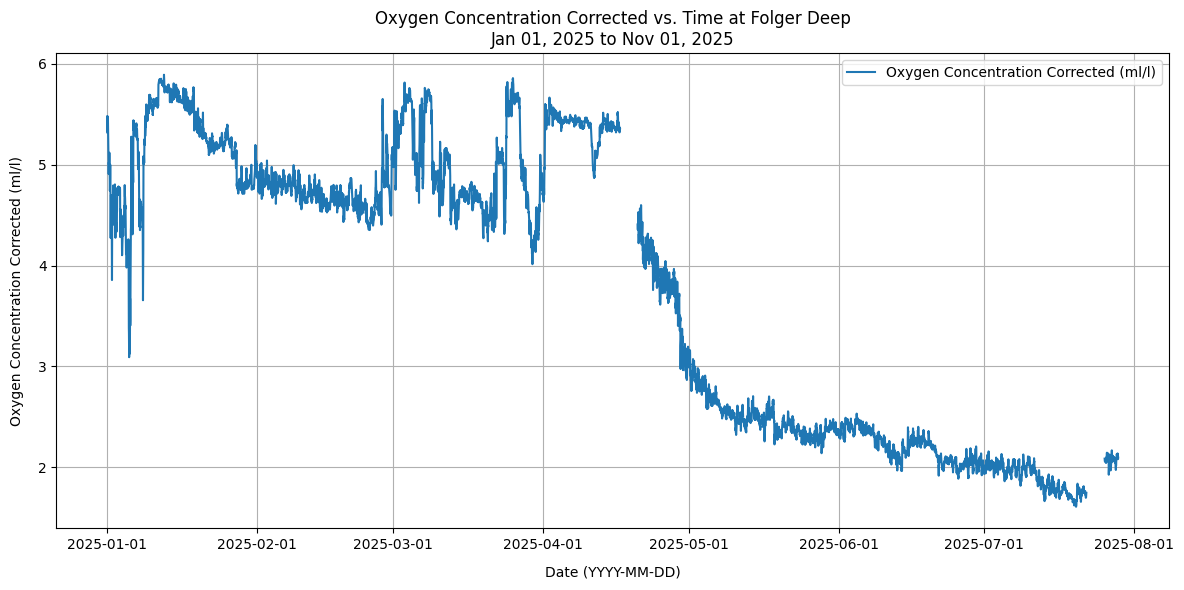

In [17]:
if resample:

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot time vs property value columns from the data frame
    plt.plot(prop_df["time"], prop_df[chosen_property], label=f"{name} ({unit})")

    # Set title
    """ Below we set our title using formatted strings - 'f strings'. This lets us insert variable values 
    (like name, locationCode, or date) directly into the text using {braces}."""
    plt.title(f"{name} vs. Time at Folger Deep" # INTERACTIVE:  Modify your title here (in quotes).
            f"\n{start_time.strftime('%b %d, %Y')} to {end_time.strftime('%b %d, %Y')}")
    
    # Set labels
    plt.xlabel("Date (YYYY-MM-DD)", labelpad=10)
    plt.ylabel(f"{name} ({unit})", labelpad=10)

    # Format x-axis dates according to ISO format: YYYY-MM-DD
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    
    # Add grid, legend, and layout fixes
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Show plot
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1cd2cd01-70e8-41b6-af2d-f797c6675dbe' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>